In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, RMSprop
from keras.layers import BatchNormalization
from keras.layers import Dropout

from sklearn.decomposition import PCA
from modules.pca_module import perform_pca
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE


### 1-Load data

In [58]:
#modify this with the name of the paths to read
outcomes_a = pd.read_csv("data/outcomes/Outcomes-a.txt")
outcomes_b = pd.read_csv("data/outcomes/Outcomes-b.txt")
outcomes_c = pd.read_csv("data/outcomes/Outcomes-c.txt")

outcomes_a = outcomes_a.drop(columns=['SOFA', 'SAPS-I', 'Survival'])
outcomes_b = outcomes_b.drop(columns=['SOFA', 'SAPS-I', 'Survival'])
outcomes_c = outcomes_c.drop(columns=['SOFA', 'SAPS-I', 'Survival'])

# Specify your choice of split for training and testing
choice_train = '_a'  # Choose from '_a', '_b', or '_c' for training
choice_test = '_b'   # Choose from '_a', '_b', or '_c' for testing

In [59]:
knn_df = pd.read_csv('clean_data/withsetc/KNN_imputed_df.csv')
m1_df = pd.read_csv('clean_data/withsetc/minus1_imputed_df.csv')

In [60]:
pd.options.display.max_columns = None
knn_df.sample()

,RecordID,Age,Gender,ICUType,BMI,MechVent,BUN_median,BUN_mad,BUN_slope,Creatinine_median,Creatinine_mad,FiO2_median,FiO2_max,FiO2_mad,GCS_median,GCS_mad,Glucose_48median,Glucose_median,Glucose_max,Glucose_mad,Glucose_slope,HCO3_median,HCO3_mad,HCT_median,HCT_mad,HR_median,HR_max,HR_mad,HR_slope,K_48median,K_median,K_max,K_mad,Lactate_median,Lactate_mad,Mg_48median,Mg_median,Mg_max,Mg_mad,MAP_median,MAP_max,MAP_mad,MAP_last,MAP_slope,Na_median,Na_mad,Na_slope,NIMAP_median,NIMAP_max,NIMAP_mad,NIMAP_last,NIMAP_slope,PaCO2_median,PaCO2_max,PaCO2_mad,PaCO2_slope,PaO2_48median,PaO2_median,PaO2_max,PaO2_mad,PaO2_slope,pH_median,pH_mad,Platelets_median,Platelets_mad,Platelets_slope,Temp_median,Temp_max,Temp_mad,Temp_last,Urine_median,Urine_max,Urine_mad,Urine_last,Urine_slope,WBC_median,WBC_mad,WBC_slope,Weight_24median,Weight_mad,Weight_slope,Length_of_stay,In-hospital_death
2318,138383.0,53.0,1,4,29.687891,1,27.0,7.407407,-0.166667,1.1,9.090909,0.49825,0.66675,5.485882,15.0,0.0,178.0,140.0,178.0,27.142857,3.166667,25.5,5.882353,39.4,1.77665,69.0,97.0,5.797101,0.091522,4.8,4.8,4.8,0.0,2.36655,13.136004,1.7,1.7,1.7,0.0,78.9875,102.8275,7.64523,81.1125,0.038614,136.5,0.3663,-0.041667,93.0,119.7,8.602151,106.7,0.377763,39.48625,46.04,5.88124,-0.050162,115.81875,132.6825,229.5175,17.700665,-3.908398,7.384837,0.336691,67.5,11.851852,-0.716667,36.35,36.9,0.275103,36.9,300.0,300.0,0.0,300.0,-5.809364e-15,5.7,1.754386,-0.000595,86.0,0.0,0.024478,14,0


In [61]:
knn_df.shape , m1_df.shape

((12000, 83), (12000, 83))

### 2-Look at the distribution target("type") variable
As both df are the same and its difference is the NaN imputation, the outcomes distribution will be the same

In [62]:
knn_df['In-hospital_death'].value_counts()

In-hospital_death
0    10293
1     1707
Name: count, dtype: int64

In [63]:
negative_samples = knn_df['In-hospital_death'].value_counts()[0]
positive_samples = knn_df['In-hospital_death'].value_counts()[1]
total_samples = negative_samples + positive_samples
weight_for_class_0 = total_samples / (negative_samples * 2) 
weight_for_class_1 = total_samples / (positive_samples * 2) 

In [64]:
import tensorflow as tf
from tensorflow.keras.losses import Loss

class WeightedBinaryCrossEntropy(Loss):
    def __init__(self, class_weights):
        super(WeightedBinaryCrossEntropy, self).__init__()
        self.class_weights = class_weights

    def call(self, y_true, y_pred):
        # Cast tensors to float32 to ensure type consistency
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Apply weights to the binary crossentropy loss
        loss = -(self.class_weights * y_true * tf.math.log(y_pred + 1e-10) + (1 - y_true) * tf.math.log(1 - y_pred + 1e-10))
        return tf.reduce_mean(loss)

# Example usage:
class_weights = tf.constant([[weight_for_class_0], [weight_for_class_1]])  # Example weights for the two classes (adjust as needed)
weighted_binary_crossentropy = WeightedBinaryCrossEntropy(class_weights)

# Register the custom loss function
tf.keras.utils.get_custom_objects()['weighted_binary_crossentropy'] = weighted_binary_crossentropy

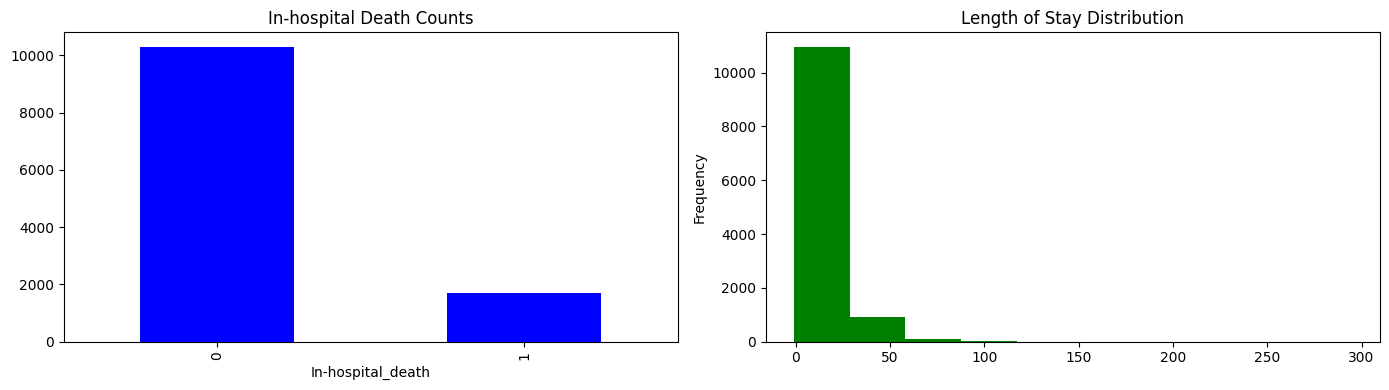

In [65]:
import matplotlib.pyplot as plt

# Create a new figure and axis objects
fig, axs = plt.subplots(1, 2, figsize=(14, 4))  # 1 row, 2 columns for two plots

# Plot the count of each value in the 'In-hospital_death' column as a bar plot
knn_df['In-hospital_death'].value_counts().plot(kind="bar", ax=axs[0], color='blue')

# Plot the distribution of values in the 'Length_of_stay' column as a histogram
knn_df['Length_of_stay'].plot(kind="hist", ax=axs[1], color='green')

# Set titles for each subplot
axs[0].set_title('In-hospital Death Counts')
axs[1].set_title('Length of Stay Distribution')

# Show the plots
plt.tight_layout()
plt.show()


### 3-IN_HOSPITAL_DEATH PREDICTION

**3.1 -Create a function that**
 - remove the outcome columns and palaces RecordID as index
 - splits the data
 - normalizes the data
 - creates / compiles and trains a basic model
 - predicts the outcomes


*FUNCTION PARAMETERS*
- Input layer - 64 nodes, activation ReLu, input features

- Hidden layer - 64 nodes activation ReLu

- Output - 1 node, activation sigmoid

*Optimization and cost for the model*
- loss - "mse" # Mean Squared Error

- optimizer - SGD # Stochastic Gradient Descent

- metrics - "mae" # Mean average error  

In order to keep all the results we will save them to finally summarize in a df

In [66]:
# Create a df to save the results
data = {
    "Model": [],
    "Method": [],
    "mean_precision": [],
    "mean_recall": [],
    "stdev_precision": [],
    "stdev_recall": []
}

df_results = pd.DataFrame(data)


In [67]:
knn_df.sample()

,RecordID,Age,Gender,ICUType,BMI,MechVent,BUN_median,BUN_mad,BUN_slope,Creatinine_median,Creatinine_mad,FiO2_median,FiO2_max,FiO2_mad,GCS_median,GCS_mad,Glucose_48median,Glucose_median,Glucose_max,Glucose_mad,Glucose_slope,HCO3_median,HCO3_mad,HCT_median,HCT_mad,HR_median,HR_max,HR_mad,HR_slope,K_48median,K_median,K_max,K_mad,Lactate_median,Lactate_mad,Mg_48median,Mg_median,Mg_max,Mg_mad,MAP_median,MAP_max,MAP_mad,MAP_last,MAP_slope,Na_median,Na_mad,Na_slope,NIMAP_median,NIMAP_max,NIMAP_mad,NIMAP_last,NIMAP_slope,PaCO2_median,PaCO2_max,PaCO2_mad,PaCO2_slope,PaO2_48median,PaO2_median,PaO2_max,PaO2_mad,PaO2_slope,pH_median,pH_mad,Platelets_median,Platelets_mad,Platelets_slope,Temp_median,Temp_max,Temp_mad,Temp_last,Urine_median,Urine_max,Urine_mad,Urine_last,Urine_slope,WBC_median,WBC_mad,WBC_slope,Weight_24median,Weight_mad,Weight_slope,Length_of_stay,In-hospital_death
3504,141440.0,60.0,1,2,29.102099,1,10.0,10.0,-0.193878,0.8,0.0,0.4,0.4,0.0,6.5,53.846154,93.0,97.0,111.0,8.247423,-0.73997,26.0,11.538462,27.4,5.474453,77.0,116.0,5.844156,0.5172,4.2,4.0,4.5,6.25,2.15,25.581395,1.8,1.9,2.0,5.263158,75.0,88.0,6.666667,75.0,-0.005719,139.5,0.358423,0.047619,74.0,115.0,0.0,74.0,-20.5,36.0,43.0,16.666667,0.187419,132.0,234.0,438.0,54.700855,-9.229449,7.46,0.670241,169.5,12.979351,-2.170886,37.0,38.4,0.540541,38.2,130.0,450.0,65.384615,60.0,-4.573602,9.55,15.706806,0.105907,79.903,0.0,2.693038e-16,6,0


In [68]:
def f1_scorer(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.round(y_pred), tf.float32)  # Convert probabilities to binary predictions

    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    fp = tf.reduce_sum((1 - y_true) * y_pred, axis=0)
    fn = tf.reduce_sum(y_true * (1 - y_pred), axis=0)

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)  # Replace NaN values with zeros

    return tf.reduce_mean(f1)

In [69]:
def NN_basic_model(df, outcomes_a, outcomes_b, outcomes_c, choice_train, choice_test):
    """
    Builds and trains a basic neural network model for binary classification.

    Args:
        df (pd.DataFrame): Input DataFrame containing features and target variable.
        outcomes_a (str): outcomes for split A.
        outcomes_b (str): outcomes for split B.
        outcomes_c (str): outcomes for split C
        choice_train (str): Name of the df split to use for training data.
        choice_test (str): Name of the df split to use for testing data.


    Returns:
        float: F1-score on the test set.
    """
    df = df.drop(columns=['In-hospital_death', 'Length_of_stay'])
    df_outcomes_a_df = pd.merge(df, outcomes_a, on="RecordID", how="inner")
    df_outcomes_b_df = pd.merge(df, outcomes_b, on="RecordID", how="inner")
    df_outcomes_c_df = pd.merge(df, outcomes_c, on="RecordID", how="inner")

    # Extract features and target variable
    # Extract features and target variable
    # For training set X_train and y_train
    X_a = df_outcomes_a_df.drop(columns=['In-hospital_death', 'Length_of_stay', 'RecordID'])
    y_a = df_outcomes_a_df['In-hospital_death']

    # For testing set B X_test_b and y_test_b
    X_b = df_outcomes_b_df.drop(columns=['In-hospital_death', 'Length_of_stay', 'RecordID'])
    y_b = df_outcomes_b_df['In-hospital_death']

    # For testing set C X_test_c and y_test_c
    X_c = df_outcomes_c_df.drop(columns=['In-hospital_death', 'Length_of_stay', 'RecordID'])
    y_c = df_outcomes_c_df['In-hospital_death']

    # Define a dictionary to store the splits
    data_splits = {'_a': (X_a, y_a), '_b': (X_b, y_b), '_c': (X_c, y_c)}

    # Get the selected splits for training and testing
    X_train, y_train = data_splits[choice_train]
    X_test, y_test = data_splits[choice_test]

    # Data normalization
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Model architecture with BatchNormalization and Dropout
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))  # Add dropout layer
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer and compilation
    sgd = SGD(learning_rate=0.1)
    model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=[f1_scorer, "accuracy"])

    # Model training
    epochs = 20
    batch_size = 32
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Getting predictions
    y_pred = model.predict(X_test)
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)

    # Calculate metrics
 
    precision = precision_score(y_test, y_pred_binary)
    print(f"precision on test set: {precision:.2f}")
    recall = recall_score(y_test, y_pred_binary)
    print(f"recall on test set: {recall:.2f}")
    f1 = f1_score(y_test, y_pred_binary)
    print(f"f1 score on test set: {f1:.2f}")
    
    return y_test, y_pred_binary

**3.2- Evaluation of the model performance on the two loaded dataframes**

in order to have more information we will run each model 10 times

In [70]:
def run_function_10_times(df, function, *args, **kwargs):
    precision = []
    recall = []
    for i in range(10):   
        y_test, y_pred = function(df, *args, **kwargs)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        precision.append(prec)
        recall.append(rec)
    return np.mean(precision), np.mean(recall), np.std(precision), np.std(recall)

In [71]:
mean_prec, mean_rec, stdev_prec, stdev_recall =  run_function_10_times(knn_df, NN_basic_model, outcomes_a, outcomes_b, outcomes_c, choice_train, choice_test)

Epoch 1/20
125/125 [==============================] - 1s 1ms/step - loss: 0.3925 - f1_scorer: 0.0912 - accuracy: 0.8482
Epoch 2/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3281 - f1_scorer: 0.2398 - accuracy: 0.8702
Epoch 3/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3099 - f1_scorer: 0.2830 - accuracy: 0.8735
Epoch 4/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2876 - f1_scorer: 0.3552 - accuracy: 0.8783
Epoch 5/20
125/125 [==============================] - 0s 990us/step - loss: 0.2838 - f1_scorer: 0.3737 - accuracy: 0.8805
Epoch 6/20
125/125 [==============================] - 0s 993us/step - loss: 0.2634 - f1_scorer: 0.4465 - accuracy: 0.8898
Epoch 7/20
125/125 [==============================] - 0s 2ms/step - loss: 0.2555 - f1_scorer: 0.4713 - accuracy: 0.8905
Epoch 8/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2467 - f1_scorer: 0.4934 - accuracy: 0.8980
Epoch 9/20
125/125 [================

In [72]:
print(f"basic_NN for Knn_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_basic'
method_name = "knn_df"
df_results.loc[0] = [Model, method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]
df_results

basic_NN for Knn_df : mean_prec = 0.4640727104845791, mean_rec =  0.35686619718309864, stdev_prec = 0.023332492366374587, stdev_recall = 0.03361754169036917


,Model,Method,mean_precision,mean_recall,stdev_precision,stdev_recall
0,NN_basic,knn_df,0.464073,0.356866,0.023332,0.033618


In [73]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(m1_df, NN_basic_model, outcomes_a, outcomes_b, outcomes_c, choice_train, choice_test)

Epoch 1/20
125/125 [==============================] - 1s 1ms/step - loss: 0.3931 - f1_scorer: 0.0752 - accuracy: 0.8553
Epoch 2/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3384 - f1_scorer: 0.1667 - accuracy: 0.8590
Epoch 3/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3229 - f1_scorer: 0.2322 - accuracy: 0.8687
Epoch 4/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3045 - f1_scorer: 0.3061 - accuracy: 0.8742
Epoch 5/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2958 - f1_scorer: 0.3321 - accuracy: 0.8752
Epoch 6/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2865 - f1_scorer: 0.3784 - accuracy: 0.8835
Epoch 7/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2708 - f1_scorer: 0.3791 - accuracy: 0.8863
Epoch 8/20
125/125 [==============================] - 0s 2ms/step - loss: 0.2663 - f1_scorer: 0.3927 - accuracy: 0.8873
Epoch 9/20
125/125 [====================

In [74]:
print(f"basic_NN for m1_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_basic'
method_name = "m1_df"
df_results.loc[1] = [Model,method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]

basic_NN for m1_df : mean_prec = 0.4444765255742742, mean_rec =  0.31795774647887326, stdev_prec = 0.027003094551578205, stdev_recall = 0.062291110950692896


**3.3 -Use PCA in the models to check for improvement.**

As PCA already requieres standarization of numerica features a new function must be created but the model will be the same. 

In [75]:
def NN_PCA_model(df, outcomes_a, outcomes_b, outcomes_c, choice_train, choice_test):
    """
    Builds and trains an improved neural network model for binary classification using PCA.
   
    Args:
        df (pd.DataFrame): Input DataFrame containing features and target variable.
        outcomes_a (str): outcomes for split A.
        outcomes_b (str): outcomes for split B.
        outcomes_c (str): outcomes for split C
        choice_train (str): Name of the df split to use for training data.
        choice_test (str): Name of the df split to use for testing data.


    Returns:
        float: F1-score on the test set.
    """
    df = df.drop(columns=['In-hospital_death', 'Length_of_stay'])
    df_outcomes_a_df = pd.merge(df, outcomes_a, on="RecordID", how="inner")
    df_outcomes_b_df = pd.merge(df, outcomes_b, on="RecordID", how="inner")
    df_outcomes_c_df = pd.merge(df, outcomes_c, on="RecordID", how="inner")

    # Extract features and target variable
    # Extract features and target variable
    # For training set X_train and y_train
    X_a = df_outcomes_a_df.drop(columns=['In-hospital_death', 'Length_of_stay'])
    y_a = df_outcomes_a_df['In-hospital_death']

    # For testing set B X_test_b and y_test_b
    X_b = df_outcomes_b_df.drop(columns=['In-hospital_death', 'Length_of_stay'])
    y_b = df_outcomes_b_df['In-hospital_death']

    # For testing set C X_test_c and y_test_c
    X_c = df_outcomes_c_df.drop(columns=['In-hospital_death', 'Length_of_stay'])
    y_c = df_outcomes_c_df['In-hospital_death']

    # Define a dictionary to store the splits
    data_splits = {'_a': (X_a, y_a), '_b': (X_b, y_b), '_c': (X_c, y_c)}

    # Get the selected splits for training and testing
    X_train, y_train = data_splits[choice_train]
    X_test, y_test = data_splits[choice_test]

    #exclude categorical features from PCA transformation
    categorical_features = ['Gender', 'ICUType', 'MechVent']
    X_train, X_test, pca, explained_variance_ratio = perform_pca(train_data = X_train, test_data = X_test, n_components=0.95, categorical_features=categorical_features)

    # Model architecture with BatchNormalization and Dropout
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))  # Add dropout layer
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer and compilation
    sgd = SGD(learning_rate=0.1)
    model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])

    # Model training
    epochs = 20
    batch_size = 32
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Getting predictions
    y_pred = model.predict(X_test)
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)

    # Calculate metrics
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    print(f"Precision on test set: {precision:.2f}")
    print(f"Recall on test set: {recall:.2f}")

    return y_test, y_pred_binary



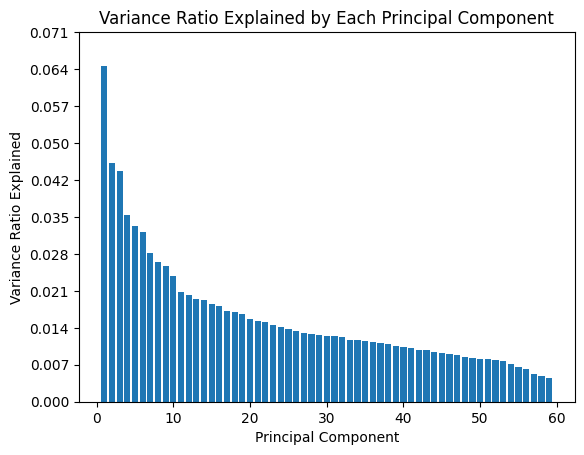

Number of components required to achieve 0.95 variance explained: 59
Epoch 1/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3850 - accuracy: 0.8568
Epoch 2/20
125/125 [==============================] - 0s 944us/step - loss: 0.3344 - accuracy: 0.8665
Epoch 3/20
125/125 [==============================] - 0s 907us/step - loss: 0.3109 - accuracy: 0.8735
Epoch 4/20
125/125 [==============================] - 0s 893us/step - loss: 0.2909 - accuracy: 0.8802
Epoch 5/20
125/125 [==============================] - 0s 910us/step - loss: 0.2805 - accuracy: 0.8857
Epoch 6/20
125/125 [==============================] - 0s 931us/step - loss: 0.2712 - accuracy: 0.8907
Epoch 7/20
125/125 [==============================] - 0s 935us/step - loss: 0.2696 - accuracy: 0.8867
Epoch 8/20
125/125 [==============================] - 0s 911us/step - loss: 0.2518 - accuracy: 0.8923
Epoch 9/20
125/125 [==============================] - 0s 928us/step - loss: 0.2455 - accuracy: 0.8997
Epoch 10/20
125

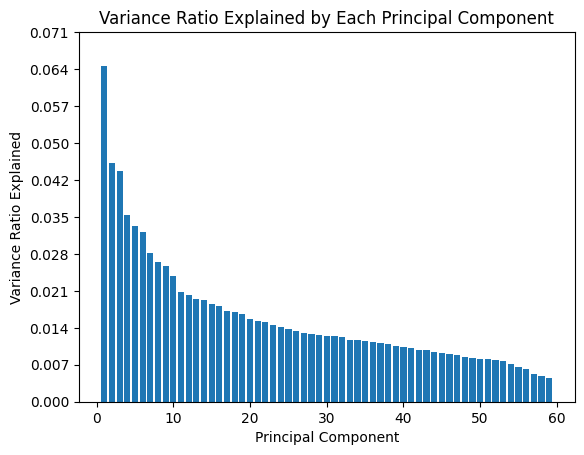

Number of components required to achieve 0.95 variance explained: 59
Epoch 1/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3829 - accuracy: 0.8553
Epoch 2/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3240 - accuracy: 0.8652
Epoch 3/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3061 - accuracy: 0.8752
Epoch 4/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2919 - accuracy: 0.8817
Epoch 5/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2868 - accuracy: 0.8838
Epoch 6/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2777 - accuracy: 0.8832
Epoch 7/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2631 - accuracy: 0.8920
Epoch 8/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2532 - accuracy: 0.8945
Epoch 9/20
125/125 [==============================] - 0s 2ms/step - loss: 0.2461 - accuracy: 0.8972
Epoch 10/20
125/125 [==========

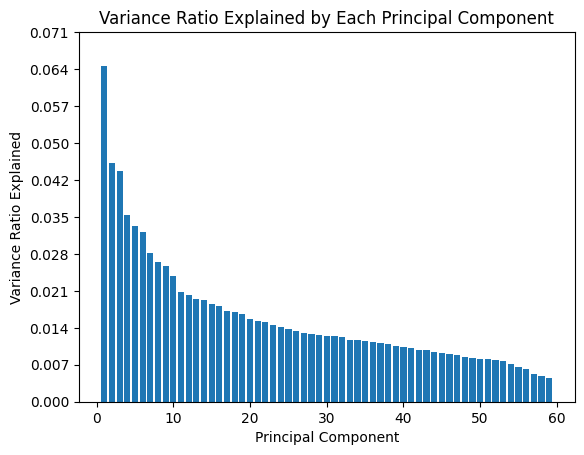

Number of components required to achieve 0.95 variance explained: 59
Epoch 1/20
125/125 [==============================] - 1s 1ms/step - loss: 0.3803 - accuracy: 0.8510
Epoch 2/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3198 - accuracy: 0.8723
Epoch 3/20
125/125 [==============================] - 0s 968us/step - loss: 0.3097 - accuracy: 0.8745
Epoch 4/20
125/125 [==============================] - 0s 2ms/step - loss: 0.2912 - accuracy: 0.8795
Epoch 5/20
125/125 [==============================] - 0s 960us/step - loss: 0.2805 - accuracy: 0.8805
Epoch 6/20
125/125 [==============================] - 0s 944us/step - loss: 0.2712 - accuracy: 0.8870
Epoch 7/20
125/125 [==============================] - 0s 951us/step - loss: 0.2656 - accuracy: 0.8895
Epoch 8/20
125/125 [==============================] - 0s 992us/step - loss: 0.2494 - accuracy: 0.8950
Epoch 9/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2480 - accuracy: 0.8972
Epoch 10/20
125/125 [

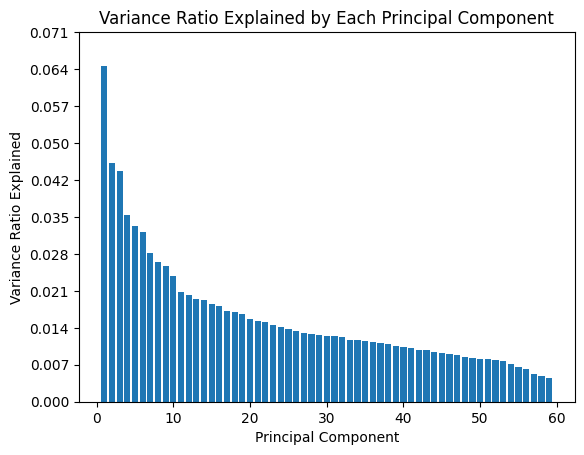

Number of components required to achieve 0.95 variance explained: 59
Epoch 1/20
125/125 [==============================] - 1s 1ms/step - loss: 0.3948 - accuracy: 0.8533
Epoch 2/20
125/125 [==============================] - 0s 2ms/step - loss: 0.3307 - accuracy: 0.8675
Epoch 3/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3141 - accuracy: 0.8723
Epoch 4/20
125/125 [==============================] - 0s 990us/step - loss: 0.2963 - accuracy: 0.8802
Epoch 5/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2911 - accuracy: 0.8805
Epoch 6/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2821 - accuracy: 0.8878
Epoch 7/20
125/125 [==============================] - 0s 911us/step - loss: 0.2699 - accuracy: 0.8890
Epoch 8/20
125/125 [==============================] - 0s 977us/step - loss: 0.2599 - accuracy: 0.8938
Epoch 9/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2544 - accuracy: 0.8928
Epoch 10/20
125/125 [====

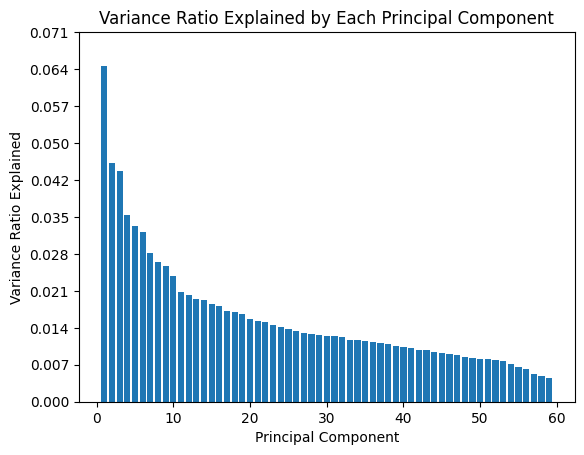

Number of components required to achieve 0.95 variance explained: 59
Epoch 1/20
125/125 [==============================] - 1s 1ms/step - loss: 0.3970 - accuracy: 0.8480
Epoch 2/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3296 - accuracy: 0.8655
Epoch 3/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3119 - accuracy: 0.8705
Epoch 4/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2887 - accuracy: 0.8805
Epoch 5/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2806 - accuracy: 0.8795
Epoch 6/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2740 - accuracy: 0.8860
Epoch 7/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2616 - accuracy: 0.8928
Epoch 8/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2517 - accuracy: 0.8953
Epoch 9/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2430 - accuracy: 0.8963
Epoch 10/20
125/125 [==========

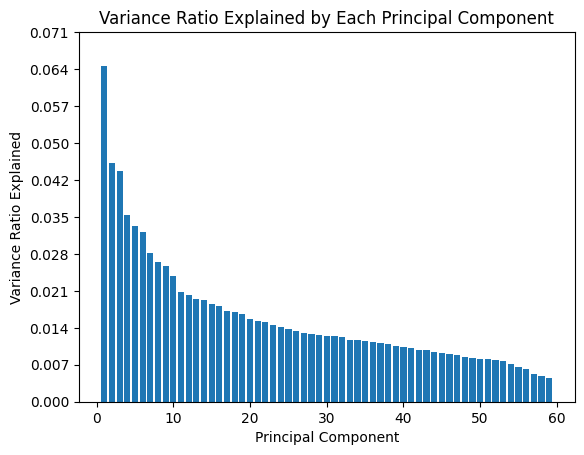

Number of components required to achieve 0.95 variance explained: 59
Epoch 1/20
125/125 [==============================] - 1s 1ms/step - loss: 0.3870 - accuracy: 0.8460
Epoch 2/20
125/125 [==============================] - 0s 960us/step - loss: 0.3310 - accuracy: 0.8683
Epoch 3/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3078 - accuracy: 0.8730
Epoch 4/20
125/125 [==============================] - 0s 946us/step - loss: 0.3024 - accuracy: 0.8765
Epoch 5/20
125/125 [==============================] - 0s 952us/step - loss: 0.2882 - accuracy: 0.8802
Epoch 6/20
125/125 [==============================] - 0s 911us/step - loss: 0.2746 - accuracy: 0.8832
Epoch 7/20
125/125 [==============================] - 0s 903us/step - loss: 0.2739 - accuracy: 0.8840
Epoch 8/20
125/125 [==============================] - 0s 919us/step - loss: 0.2674 - accuracy: 0.8852
Epoch 9/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2494 - accuracy: 0.8995
Epoch 10/20
125/125

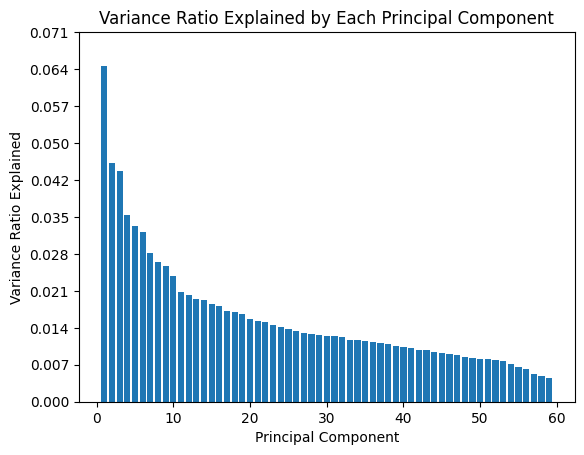

Number of components required to achieve 0.95 variance explained: 59
Epoch 1/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3854 - accuracy: 0.8595
Epoch 2/20
125/125 [==============================] - 0s 2ms/step - loss: 0.3373 - accuracy: 0.8683
Epoch 3/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3079 - accuracy: 0.8748
Epoch 4/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2921 - accuracy: 0.8832
Epoch 5/20
125/125 [==============================] - 0s 988us/step - loss: 0.2802 - accuracy: 0.8860
Epoch 6/20
125/125 [==============================] - 0s 985us/step - loss: 0.2677 - accuracy: 0.8878
Epoch 7/20
125/125 [==============================] - 0s 999us/step - loss: 0.2617 - accuracy: 0.8915
Epoch 8/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2523 - accuracy: 0.8953
Epoch 9/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2475 - accuracy: 0.8938
Epoch 10/20
125/125 [====

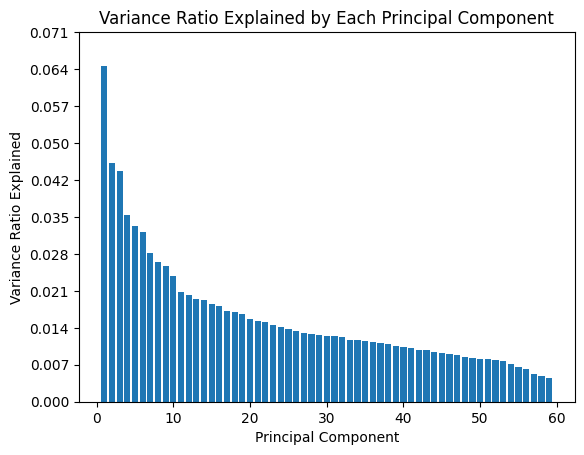

Number of components required to achieve 0.95 variance explained: 59
Epoch 1/20
125/125 [==============================] - 1s 1ms/step - loss: 0.3850 - accuracy: 0.8525
Epoch 2/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3206 - accuracy: 0.8712
Epoch 3/20
125/125 [==============================] - 0s 992us/step - loss: 0.3015 - accuracy: 0.8755
Epoch 4/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2946 - accuracy: 0.8755
Epoch 5/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2787 - accuracy: 0.8790
Epoch 6/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2665 - accuracy: 0.8867
Epoch 7/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2594 - accuracy: 0.8950
Epoch 8/20
125/125 [==============================] - 0s 994us/step - loss: 0.2558 - accuracy: 0.8910
Epoch 9/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2375 - accuracy: 0.9000
Epoch 10/20
125/125 [======

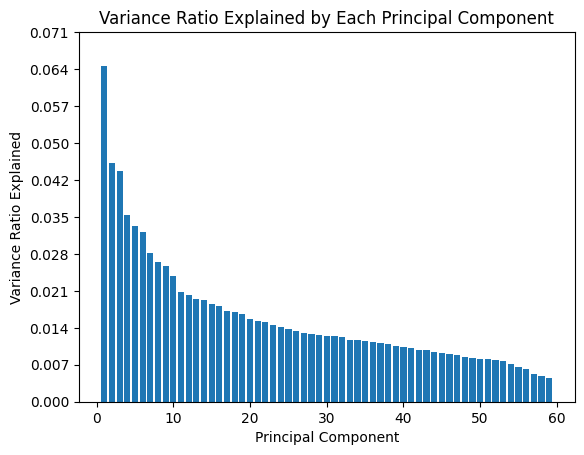

Number of components required to achieve 0.95 variance explained: 59
Epoch 1/20
125/125 [==============================] - 1s 1ms/step - loss: 0.3955 - accuracy: 0.8430
Epoch 2/20
125/125 [==============================] - 0s 922us/step - loss: 0.3184 - accuracy: 0.8733
Epoch 3/20
125/125 [==============================] - 0s 927us/step - loss: 0.3090 - accuracy: 0.8763
Epoch 4/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2946 - accuracy: 0.8785
Epoch 5/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2773 - accuracy: 0.8880
Epoch 6/20
125/125 [==============================] - 0s 967us/step - loss: 0.2794 - accuracy: 0.8823
Epoch 7/20
125/125 [==============================] - 0s 944us/step - loss: 0.2680 - accuracy: 0.8920
Epoch 8/20
125/125 [==============================] - 0s 927us/step - loss: 0.2487 - accuracy: 0.8953
Epoch 9/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2474 - accuracy: 0.8945
Epoch 10/20
125/125 [

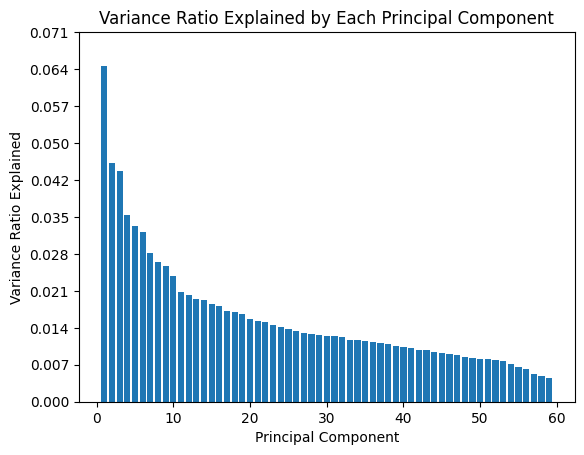

Number of components required to achieve 0.95 variance explained: 59
Epoch 1/20
125/125 [==============================] - 1s 1ms/step - loss: 0.3885 - accuracy: 0.8508
Epoch 2/20
125/125 [==============================] - 0s 927us/step - loss: 0.3280 - accuracy: 0.8702
Epoch 3/20
125/125 [==============================] - 0s 962us/step - loss: 0.3129 - accuracy: 0.8733
Epoch 4/20
125/125 [==============================] - 0s 919us/step - loss: 0.2960 - accuracy: 0.8785
Epoch 5/20
125/125 [==============================] - 0s 953us/step - loss: 0.2868 - accuracy: 0.8783
Epoch 6/20
125/125 [==============================] - 0s 968us/step - loss: 0.2813 - accuracy: 0.8790
Epoch 7/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2759 - accuracy: 0.8780
Epoch 8/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2659 - accuracy: 0.8903
Epoch 9/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2569 - accuracy: 0.8972
Epoch 10/20
125/125 [

In [76]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(knn_df,NN_PCA_model, outcomes_a, outcomes_b, outcomes_c, choice_train, choice_test)

In [77]:
print(f"basic_NN_PCA for knn_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_basic'
method_name = "PCA_knn_df"
df_results.loc[2] = [Model,method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]
df_results

basic_NN_PCA for knn_df : mean_prec = 0.45746245120432716, mean_rec =  0.3427816901408451, stdev_prec = 0.024969865617936713, stdev_recall = 0.04766577010553817


,Model,Method,mean_precision,mean_recall,stdev_precision,stdev_recall
0,NN_basic,knn_df,0.464073,0.356866,0.023332,0.033618
1,NN_basic,m1_df,0.444477,0.317958,0.027003,0.062291
2,NN_basic,PCA_knn_df,0.457462,0.342782,0.024970,0.047666


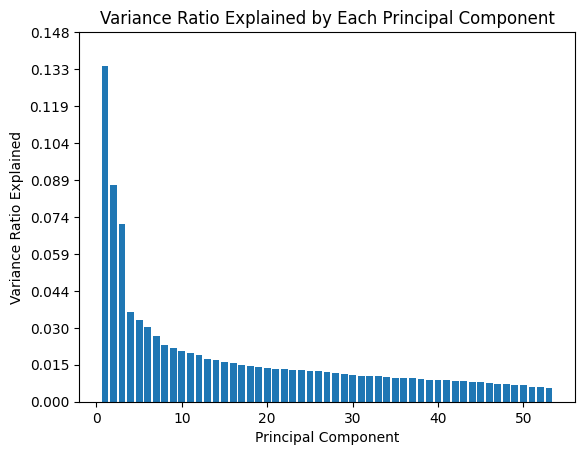

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/20
125/125 [==============================] - 1s 1ms/step - loss: 0.3887 - accuracy: 0.8475
Epoch 2/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3346 - accuracy: 0.8662
Epoch 3/20
125/125 [==============================] - 0s 2ms/step - loss: 0.3235 - accuracy: 0.8643
Epoch 4/20
125/125 [==============================] - 0s 2ms/step - loss: 0.3130 - accuracy: 0.8715
Epoch 5/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2996 - accuracy: 0.8795
Epoch 6/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2910 - accuracy: 0.8783
Epoch 7/20
125/125 [==============================] - 0s 1000us/step - loss: 0.2873 - accuracy: 0.8775
Epoch 8/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2786 - accuracy: 0.8873
Epoch 9/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2714 - accuracy: 0.8882
Epoch 10/20
125/125 [=======

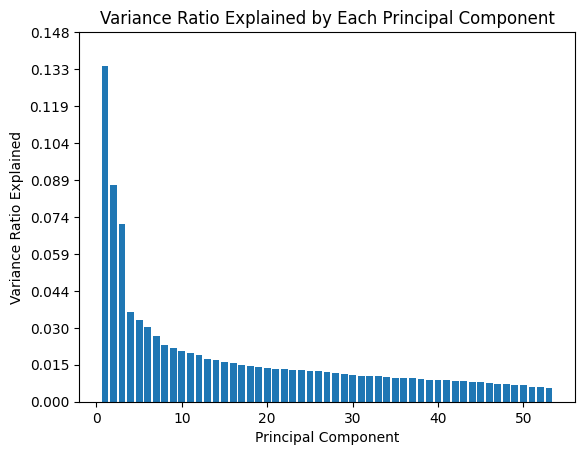

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/20
125/125 [==============================] - 1s 1ms/step - loss: 0.3770 - accuracy: 0.8585
Epoch 2/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3427 - accuracy: 0.8668
Epoch 3/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3217 - accuracy: 0.8695
Epoch 4/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3065 - accuracy: 0.8745
Epoch 5/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3028 - accuracy: 0.8720
Epoch 6/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2920 - accuracy: 0.8765
Epoch 7/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2792 - accuracy: 0.8840
Epoch 8/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2798 - accuracy: 0.8808
Epoch 9/20
125/125 [==============================] - 0s 992us/step - loss: 0.2769 - accuracy: 0.8820
Epoch 10/20
125/125 [========

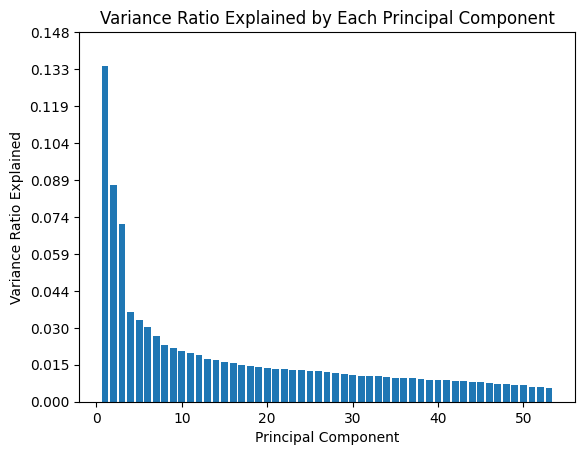

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/20
125/125 [==============================] - 1s 1ms/step - loss: 0.3978 - accuracy: 0.8505
Epoch 2/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3392 - accuracy: 0.8643
Epoch 3/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3185 - accuracy: 0.8717
Epoch 4/20
125/125 [==============================] - 0s 960us/step - loss: 0.3112 - accuracy: 0.8698
Epoch 5/20
125/125 [==============================] - 0s 968us/step - loss: 0.2953 - accuracy: 0.8752
Epoch 6/20
125/125 [==============================] - 0s 992us/step - loss: 0.2895 - accuracy: 0.8788
Epoch 7/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2841 - accuracy: 0.8810
Epoch 8/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2751 - accuracy: 0.8852
Epoch 9/20
125/125 [==============================] - 0s 2ms/step - loss: 0.2726 - accuracy: 0.8857
Epoch 10/20
125/125 [====

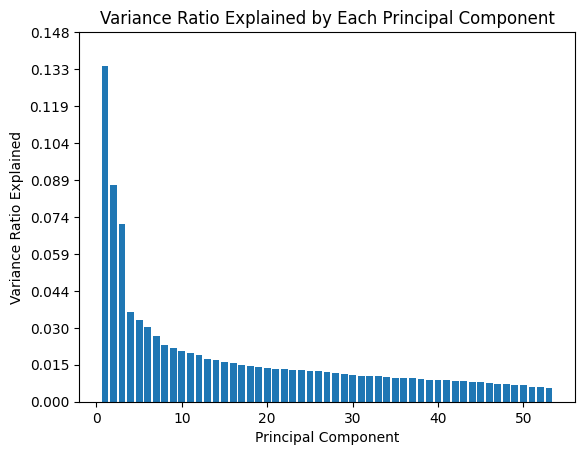

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3942 - accuracy: 0.8533
Epoch 2/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3466 - accuracy: 0.8635
Epoch 3/20
125/125 [==============================] - 0s 986us/step - loss: 0.3270 - accuracy: 0.8650
Epoch 4/20
125/125 [==============================] - 0s 944us/step - loss: 0.3138 - accuracy: 0.8683
Epoch 5/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3086 - accuracy: 0.8705
Epoch 6/20
125/125 [==============================] - 0s 968us/step - loss: 0.3033 - accuracy: 0.8737
Epoch 7/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2885 - accuracy: 0.8790
Epoch 8/20
125/125 [==============================] - 0s 976us/step - loss: 0.2846 - accuracy: 0.8802
Epoch 9/20
125/125 [==============================] - 0s 952us/step - loss: 0.2755 - accuracy: 0.8832
Epoch 10/20
125/125 [

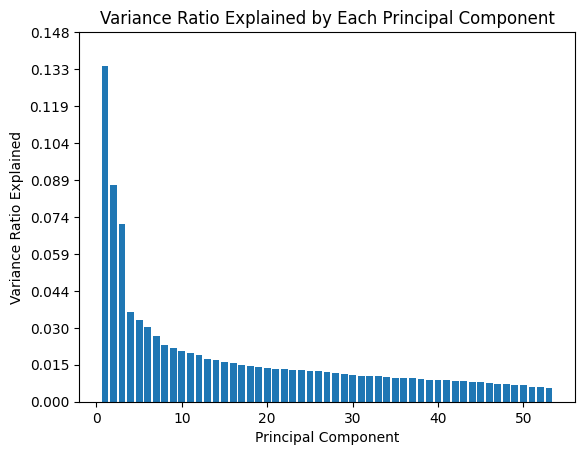

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/20
125/125 [==============================] - 1s 1ms/step - loss: 0.3905 - accuracy: 0.8535
Epoch 2/20
125/125 [==============================] - 0s 2ms/step - loss: 0.3375 - accuracy: 0.8670
Epoch 3/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3247 - accuracy: 0.8677
Epoch 4/20
125/125 [==============================] - 0s 982us/step - loss: 0.3138 - accuracy: 0.8680
Epoch 5/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3018 - accuracy: 0.8745
Epoch 6/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2948 - accuracy: 0.8740
Epoch 7/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2889 - accuracy: 0.8817
Epoch 8/20
125/125 [==============================] - 0s 976us/step - loss: 0.2818 - accuracy: 0.8820
Epoch 9/20
125/125 [==============================] - 0s 984us/step - loss: 0.2790 - accuracy: 0.8810
Epoch 10/20
125/125 [====

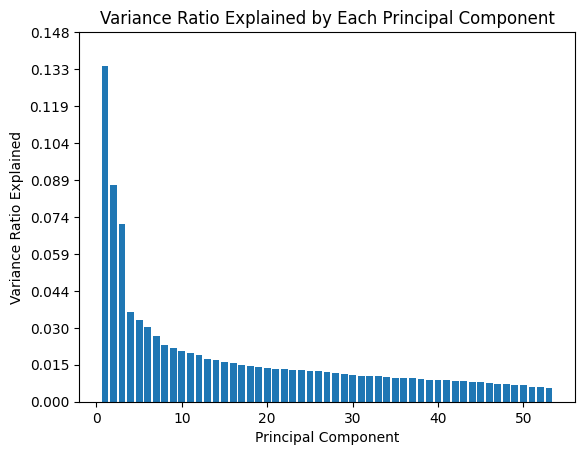

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3913 - accuracy: 0.8540
Epoch 2/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3430 - accuracy: 0.8643
Epoch 3/20
125/125 [==============================] - 0s 976us/step - loss: 0.3189 - accuracy: 0.8720
Epoch 4/20
125/125 [==============================] - 0s 952us/step - loss: 0.3127 - accuracy: 0.8740
Epoch 5/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3038 - accuracy: 0.8758
Epoch 6/20
125/125 [==============================] - 0s 947us/step - loss: 0.2915 - accuracy: 0.8788
Epoch 7/20
125/125 [==============================] - 0s 960us/step - loss: 0.2857 - accuracy: 0.8788
Epoch 8/20
125/125 [==============================] - 0s 976us/step - loss: 0.2777 - accuracy: 0.8857
Epoch 9/20
125/125 [==============================] - 0s 960us/step - loss: 0.2704 - accuracy: 0.8878
Epoch 10/20
125/125

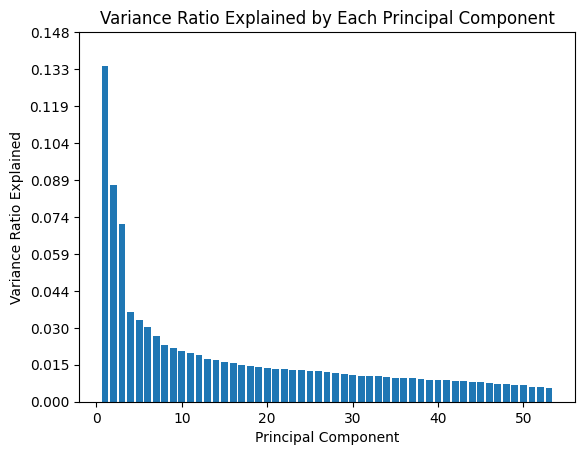

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/20
125/125 [==============================] - 1s 1ms/step - loss: 0.3989 - accuracy: 0.8525
Epoch 2/20
125/125 [==============================] - 0s 976us/step - loss: 0.3436 - accuracy: 0.8635
Epoch 3/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3263 - accuracy: 0.8677
Epoch 4/20
125/125 [==============================] - 0s 952us/step - loss: 0.3167 - accuracy: 0.8758
Epoch 5/20
125/125 [==============================] - 0s 954us/step - loss: 0.3088 - accuracy: 0.8717
Epoch 6/20
125/125 [==============================] - 0s 961us/step - loss: 0.3025 - accuracy: 0.8710
Epoch 7/20
125/125 [==============================] - 0s 992us/step - loss: 0.2921 - accuracy: 0.8752
Epoch 8/20
125/125 [==============================] - 0s 979us/step - loss: 0.2870 - accuracy: 0.8765
Epoch 9/20
125/125 [==============================] - 0s 976us/step - loss: 0.2781 - accuracy: 0.8840
Epoch 10/20
125/1

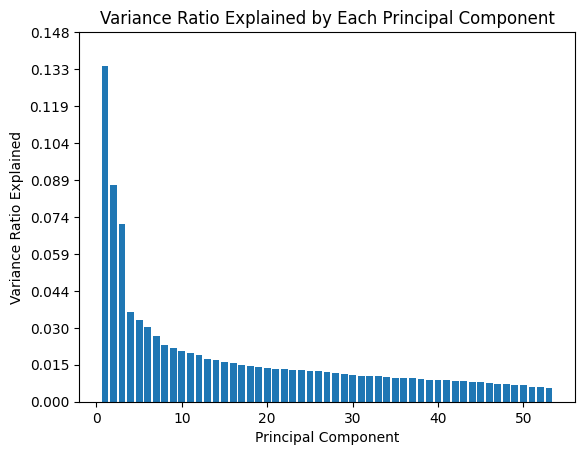

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/20
125/125 [==============================] - 1s 1ms/step - loss: 0.3772 - accuracy: 0.8583
Epoch 2/20
125/125 [==============================] - 0s 992us/step - loss: 0.3374 - accuracy: 0.8650
Epoch 3/20
125/125 [==============================] - 0s 927us/step - loss: 0.3165 - accuracy: 0.8675
Epoch 4/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3116 - accuracy: 0.8763
Epoch 5/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2998 - accuracy: 0.8720
Epoch 6/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2888 - accuracy: 0.8823
Epoch 7/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2821 - accuracy: 0.8820
Epoch 8/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2757 - accuracy: 0.8850
Epoch 9/20
125/125 [==============================] - 0s 940us/step - loss: 0.2607 - accuracy: 0.8850
Epoch 10/20
125/125 [====

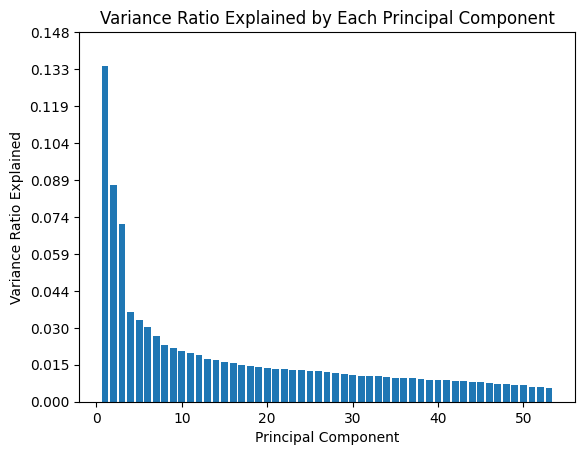

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/20
125/125 [==============================] - 0s 1ms/step - loss: 0.4002 - accuracy: 0.8520
Epoch 2/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3407 - accuracy: 0.8668
Epoch 3/20
125/125 [==============================] - 0s 952us/step - loss: 0.3261 - accuracy: 0.8710
Epoch 4/20
125/125 [==============================] - 0s 976us/step - loss: 0.3167 - accuracy: 0.8690
Epoch 5/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3050 - accuracy: 0.8745
Epoch 6/20
125/125 [==============================] - 0s 920us/step - loss: 0.2942 - accuracy: 0.8755
Epoch 7/20
125/125 [==============================] - 0s 911us/step - loss: 0.2848 - accuracy: 0.8805
Epoch 8/20
125/125 [==============================] - 0s 991us/step - loss: 0.2822 - accuracy: 0.8805
Epoch 9/20
125/125 [==============================] - 0s 960us/step - loss: 0.2700 - accuracy: 0.8875
Epoch 10/20
125/125

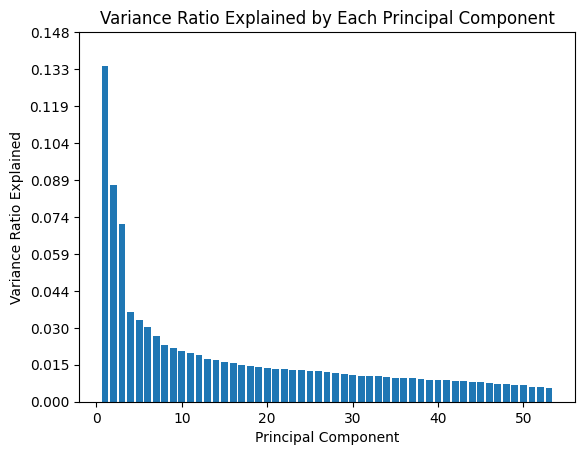

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/20
125/125 [==============================] - 1s 1ms/step - loss: 0.3882 - accuracy: 0.8562
Epoch 2/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3426 - accuracy: 0.8633
Epoch 3/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3213 - accuracy: 0.8675
Epoch 4/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3092 - accuracy: 0.8773
Epoch 5/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3037 - accuracy: 0.8788
Epoch 6/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2958 - accuracy: 0.8810
Epoch 7/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2841 - accuracy: 0.8845
Epoch 8/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2745 - accuracy: 0.8855
Epoch 9/20
125/125 [==============================] - 0s 1ms/step - loss: 0.2726 - accuracy: 0.8882
Epoch 10/20
125/125 [==========

In [78]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(m1_df,NN_PCA_model, outcomes_a, outcomes_b, outcomes_c, choice_train, choice_test)

In [79]:
print(f"basic_NN_PCA for m1_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_basic'
method_name = "PCA_m1_df"
df_results.loc[3] = [Model, method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]

basic_NN_PCA for m1_df : mean_prec = 0.45062516318759016, mean_rec =  0.29683098591549295, stdev_prec = 0.03302369555506612, stdev_recall = 0.0442122300439509


**3.4 -Managing the inbalance problem.**

Balancing the initial dataframes with two different methods:

 - SOMTE
 - RandomOverSampler

In [80]:
def NN_Balanced_model(df, method, outcomes_a, outcomes_b, outcomes_c, choice_train, choice_test):
    """
    Builds and trains an improved neural network model for binary classification with previous balanced strategy of the df.

    Args:
        Data frame.
        Method: balancing method to be applied to the Data frame

    Returns:
        Predicted value and real test value.
    """
    df = df.drop(columns=['In-hospital_death', 'Length_of_stay'])
    df_outcomes_a_df = pd.merge(df, outcomes_a, on="RecordID", how="inner")
    df_outcomes_b_df = pd.merge(df, outcomes_b, on="RecordID", how="inner")
    df_outcomes_c_df = pd.merge(df, outcomes_c, on="RecordID", how="inner")

    # Extract features and target variable
    # Extract features and target variable
    # For training set X_train and y_train
    X_a = df_outcomes_a_df.drop(columns=['In-hospital_death', 'Length_of_stay', 'RecordID'])
    y_a = df_outcomes_a_df['In-hospital_death']

    # For testing set B X_test_b and y_test_b
    X_b = df_outcomes_b_df.drop(columns=['In-hospital_death', 'Length_of_stay', 'RecordID'])
    y_b = df_outcomes_b_df['In-hospital_death']

    # For testing set C X_test_c and y_test_c
    X_c = df_outcomes_c_df.drop(columns=['In-hospital_death', 'Length_of_stay', 'RecordID'])
    y_c = df_outcomes_c_df['In-hospital_death']

    # Define a dictionary to store the splits
    data_splits = {'_a': (X_a, y_a), '_b': (X_b, y_b), '_c': (X_c, y_c)}

    # Get the selected splits for training and testing
    X_train, y_train = data_splits[choice_train]
    X_test, y_test = data_splits[choice_test]

    # Data balancing
    met = method(random_state=42)
    X_train, y_train = met.fit_resample(X_train, y_train)

    # Data normalization
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Model architecture with BatchNormalization and Dropout
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))  # Add dropout layer
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer and compilation
    sgd = SGD(learning_rate=0.1)
    model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])

    # Model training
    epochs = 20
    batch_size = 32
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Getting predictions
    y_pred = model.predict(X_test)
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)

    # Calculate metrics
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    print(f"Precision on test set: {precision:.2f}")
    print(f"Recall on test set: {recall:.2f}")

    return  y_test,y_pred_binary

as now we are using a function (NN_Balanced_model) that requiers an extra argument from run_10_times function we must use a labmda function to be able to pass this extra argument.

In [81]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(knn_df, lambda method: NN_Balanced_model(knn_df, SMOTE, outcomes_a, outcomes_b, outcomes_c, choice_train, choice_test))

Epoch 1/20
216/216 [==============================] - 1s 1ms/step - loss: 0.5076 - accuracy: 0.7494
Epoch 2/20
216/216 [==============================] - 0s 1ms/step - loss: 0.3975 - accuracy: 0.8176
Epoch 3/20
216/216 [==============================] - 0s 1ms/step - loss: 0.3385 - accuracy: 0.8513
Epoch 4/20
216/216 [==============================] - 0s 1ms/step - loss: 0.2992 - accuracy: 0.8714
Epoch 5/20
216/216 [==============================] - 0s 1ms/step - loss: 0.2643 - accuracy: 0.8864
Epoch 6/20
216/216 [==============================] - 0s 1ms/step - loss: 0.2424 - accuracy: 0.9034
Epoch 7/20
216/216 [==============================] - 0s 1ms/step - loss: 0.2238 - accuracy: 0.9093
Epoch 8/20
216/216 [==============================] - 0s 1ms/step - loss: 0.2072 - accuracy: 0.9169
Epoch 9/20
216/216 [==============================] - 0s 1ms/step - loss: 0.1900 - accuracy: 0.9241
Epoch 10/20
216/216 [==============================] - 0s 1ms/step - loss: 0.1821 - accuracy: 0.9264

In [82]:
print(f"basic_NN_smote for knn_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_basic'
method_name = "Smote_knn_df"
df_results.loc[4] = [Model,method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]

basic_NN_smote for knn_df : mean_prec = 0.36698624354624504, mean_rec =  0.37200704225352116, stdev_prec = 0.025376691532336276, stdev_recall = 0.03928108476497855


In [83]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(m1_df, lambda method: NN_Balanced_model(m1_df, SMOTE, outcomes_a, outcomes_b, outcomes_c, choice_train, choice_test))

Epoch 1/20
216/216 [==============================] - 1s 2ms/step - loss: 0.4989 - accuracy: 0.7528
Epoch 2/20
216/216 [==============================] - 0s 1ms/step - loss: 0.3884 - accuracy: 0.8295
Epoch 3/20
216/216 [==============================] - 0s 1ms/step - loss: 0.3453 - accuracy: 0.8472
Epoch 4/20
216/216 [==============================] - 0s 1ms/step - loss: 0.3182 - accuracy: 0.8580
Epoch 5/20
216/216 [==============================] - 0s 1ms/step - loss: 0.2969 - accuracy: 0.8728
Epoch 6/20
216/216 [==============================] - 0s 1ms/step - loss: 0.2599 - accuracy: 0.8974
Epoch 7/20
216/216 [==============================] - 0s 1ms/step - loss: 0.2445 - accuracy: 0.9025
Epoch 8/20
216/216 [==============================] - 0s 1ms/step - loss: 0.2348 - accuracy: 0.9042
Epoch 9/20
216/216 [==============================] - 0s 1ms/step - loss: 0.2103 - accuracy: 0.9169
Epoch 10/20
216/216 [==============================] - 0s 1ms/step - loss: 0.2057 - accuracy: 0.9179

In [84]:
print(f"basic_NN_smote for m1_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_basic'
method_name = "Smote_m1_df"
df_results.loc[5] = [Model,method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]

basic_NN_smote for m1_df : mean_prec = 0.3442388201133949, mean_rec =  0.3647887323943662, stdev_prec = 0.02459317307427477, stdev_recall = 0.04915598893083426


In [85]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(knn_df, lambda method: NN_Balanced_model(knn_df, RandomOverSampler,   outcomes_a, outcomes_b, outcomes_c, choice_train, choice_test))

Epoch 1/20
216/216 [==============================] - 1s 1ms/step - loss: 0.5456 - accuracy: 0.7213
Epoch 2/20
216/216 [==============================] - 0s 1ms/step - loss: 0.4231 - accuracy: 0.8073
Epoch 3/20
216/216 [==============================] - 0s 1ms/step - loss: 0.3677 - accuracy: 0.8350
Epoch 4/20
216/216 [==============================] - 0s 1ms/step - loss: 0.3284 - accuracy: 0.8594
Epoch 5/20
216/216 [==============================] - 0s 1ms/step - loss: 0.2936 - accuracy: 0.8788
Epoch 6/20
216/216 [==============================] - 0s 1ms/step - loss: 0.2657 - accuracy: 0.8854
Epoch 7/20
216/216 [==============================] - 0s 1ms/step - loss: 0.2399 - accuracy: 0.9039
Epoch 8/20
216/216 [==============================] - 0s 1ms/step - loss: 0.2266 - accuracy: 0.9111
Epoch 9/20
216/216 [==============================] - 0s 1ms/step - loss: 0.2089 - accuracy: 0.9172
Epoch 10/20
216/216 [==============================] - 0s 1ms/step - loss: 0.1869 - accuracy: 0.9243

In [86]:
print(f"basic_NN_ros for knn_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_basic'
method_name = "ros_knn_df"
df_results.loc[6] = [Model, method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]

basic_NN_ros for knn_df : mean_prec = 0.38496706748613646, mean_rec =  0.4014084507042254, stdev_prec = 0.01636975354556509, stdev_recall = 0.03030010903967029


In [87]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(m1_df, lambda method: NN_Balanced_model(m1_df, RandomOverSampler, outcomes_a, outcomes_b, outcomes_c, choice_train, choice_test))

Epoch 1/20
216/216 [==============================] - 1s 1ms/step - loss: 0.5651 - accuracy: 0.7072
Epoch 2/20
216/216 [==============================] - 0s 1ms/step - loss: 0.4529 - accuracy: 0.7885
Epoch 3/20
216/216 [==============================] - 0s 1ms/step - loss: 0.4048 - accuracy: 0.8147
Epoch 4/20
216/216 [==============================] - 0s 1ms/step - loss: 0.3662 - accuracy: 0.8372
Epoch 5/20
216/216 [==============================] - 0s 1ms/step - loss: 0.3358 - accuracy: 0.8506
Epoch 6/20
216/216 [==============================] - 0s 1ms/step - loss: 0.3144 - accuracy: 0.8696
Epoch 7/20
216/216 [==============================] - 0s 1ms/step - loss: 0.2953 - accuracy: 0.8823
Epoch 8/20
216/216 [==============================] - 0s 1ms/step - loss: 0.2672 - accuracy: 0.8855
Epoch 9/20
216/216 [==============================] - 0s 1ms/step - loss: 0.2424 - accuracy: 0.9003
Epoch 10/20
216/216 [==============================] - 0s 1ms/step - loss: 0.2413 - accuracy: 0.9015

In [88]:
print(f"basic_NN_ros for m1_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_basic'
method_name = "ros_m1_df"
df_results.loc[7] = [Model, method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]

basic_NN_ros for m1_df : mean_prec = 0.37206359526852106, mean_rec =  0.4211267605633803, stdev_prec = 0.03162716193836716, stdev_recall = 0.05529850825183262


In [89]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(m1_df, lambda method: NN_Balanced_model(knn_df, RandomUnderSampler, outcomes_a, outcomes_b, outcomes_c, choice_train, choice_test))

Epoch 1/20
35/35 [==============================] - 0s 1ms/step - loss: 0.6988 - accuracy: 0.5984
Epoch 2/20
35/35 [==============================] - 0s 1ms/step - loss: 0.5762 - accuracy: 0.7130
Epoch 3/20
35/35 [==============================] - 0s 1ms/step - loss: 0.5181 - accuracy: 0.7455
Epoch 4/20
35/35 [==============================] - 0s 1ms/step - loss: 0.4672 - accuracy: 0.7690
Epoch 5/20
35/35 [==============================] - 0s 1ms/step - loss: 0.4439 - accuracy: 0.7906
Epoch 6/20
35/35 [==============================] - 0s 1ms/step - loss: 0.4179 - accuracy: 0.8014
Epoch 7/20
35/35 [==============================] - 0s 1ms/step - loss: 0.4044 - accuracy: 0.8213
Epoch 8/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3903 - accuracy: 0.8303
Epoch 9/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3557 - accuracy: 0.8520
Epoch 10/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3431 - accuracy: 0.8493
Epoch 11/20
35/35 [

In [90]:
print(f"basic_NN_rus for knn_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_basic'
method_name = "rus_knn_df"
df_results.loc[8] = [Model, method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]

basic_NN_rus for knn_df : mean_prec = 0.30025114580614104, mean_rec =  0.7294014084507043, stdev_prec = 0.017959200434804923, stdev_recall = 0.02920678605930996


In [91]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(m1_df, lambda method: NN_Balanced_model(m1_df, RandomUnderSampler, outcomes_a, outcomes_b, outcomes_c, choice_train, choice_test))

Epoch 1/20
35/35 [==============================] - 1s 2ms/step - loss: 0.6861 - accuracy: 0.5776
Epoch 2/20
35/35 [==============================] - 0s 2ms/step - loss: 0.5699 - accuracy: 0.6841
Epoch 3/20
35/35 [==============================] - 0s 2ms/step - loss: 0.5048 - accuracy: 0.7608
Epoch 4/20
35/35 [==============================] - 0s 2ms/step - loss: 0.4880 - accuracy: 0.7681
Epoch 5/20
35/35 [==============================] - 0s 1ms/step - loss: 0.4561 - accuracy: 0.7825
Epoch 6/20
35/35 [==============================] - 0s 1ms/step - loss: 0.4426 - accuracy: 0.7834
Epoch 7/20
35/35 [==============================] - 0s 1ms/step - loss: 0.4073 - accuracy: 0.8141
Epoch 8/20
35/35 [==============================] - 0s 2ms/step - loss: 0.3771 - accuracy: 0.8312
Epoch 9/20
35/35 [==============================] - 0s 2ms/step - loss: 0.3671 - accuracy: 0.8430
Epoch 10/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3295 - accuracy: 0.8637
Epoch 11/20
35/35 [

In [92]:
print(f"basic_NN_rus for m1_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_basic'
method_name = "rus_m1_df"
df_results.loc[9] = [Model, method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]

basic_NN_rus for m1_df : mean_prec = 0.2830785856495835, mean_rec =  0.7390845070422534, stdev_prec = 0.012958719243358134, stdev_recall = 0.03717082597294828


In [93]:
df_results_a_vs_b= df_results.sort_index()
df_results_a_vs_b

,Model,Method,mean_precision,mean_recall,stdev_precision,stdev_recall
0,NN_basic,knn_df,0.464073,0.356866,0.023332,0.033618
1,NN_basic,m1_df,0.444477,0.317958,0.027003,0.062291
2,NN_basic,PCA_knn_df,0.457462,0.342782,0.024970,0.047666
3,NN_basic,PCA_m1_df,0.450625,0.296831,0.033024,0.044212
4,NN_basic,Smote_knn_df,0.366986,0.372007,0.025377,0.039281
5,NN_basic,Smote_m1_df,0.344239,0.364789,0.024593,0.049156
6,NN_basic,ros_knn_df,0.384967,0.401408,0.016370,0.030300
7,NN_basic,ros_m1_df,0.372064,0.421127,0.031627,0.055299
8,NN_basic,rus_knn_df,0.300251,0.729401,0.017959,0.029207
9,NN_basic,rus_m1_df,0.283079,0.739085,0.012959,0.037171


In [94]:
df_results_a_vs_b.to_csv("result_dframes/Physionet_NN_basic_a_vs_b.csv", index=False)